<a href="https://colab.research.google.com/github/nmhaddad/python-machine-learning-youtube/blob/master/cs6140projectNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pattern Recognition in Daily Top Trending YouTube Videos**

Natural Language Processing Sub-Experiment
---


# Setup

**Imports**

In [0]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
import re
import seaborn as sns
from gensim.test.utils import common_texts
from gensim.models import Phrases

%load_ext Cython
%matplotlib inline

**Load Data From Google Drive**

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read-in CSV & JSON**

In [0]:
UNITED_STATES_VID = "/content/drive/My Drive/cs6140 project/data/USvideos.csv"
videos = pd.read_csv(UNITED_STATES_VID)

UNITED_STATES_CAT = "/content/drive/My Drive/cs6140 project/data/US_category_id.json"
videos_categories = pd.read_json(UNITED_STATES_CAT)

In [4]:
videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...


In [5]:
videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


In [6]:
videos.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


# Data Pre-Processing

This block of code links the csv to json categories

In [0]:
# source: https://www.kaggle.com/skalskip/youtube-data-exploration-and-plotly-visualization

categories = {category['id']: category['snippet']['title'] for category in videos_categories['items']}
videos.insert(4, 'category', videos['category_id'].astype(str).map(categories))

**Remove Duplicates**

The outcome of this experiment will be heavily impacted by duplicate videos

In [0]:
videos.drop_duplicates(subset="title", keep="last", inplace=True)

In [9]:
print(videos.shape[0])

6455


**Creating New Attributes**

In [0]:
videos["likes_per_view"] = videos["likes"]/videos["views"]
videos["dislikes_per_view"] = videos["dislikes"]/videos["views"]
videos["comments_per_view"] = videos["comment_count"]/videos["views"]

videos["total_likes_dislikes"] = videos["likes"] + videos["dislikes"]
videos["total_likes_dislikes_per_view"] = videos["total_likes_dislikes"]/videos["views"]

videos["likes_percentage"] = videos["likes"]/videos["total_likes_dislikes"]
videos["dislikes_percentage"] =videos["dislikes"]/videos["total_likes_dislikes"]

In [0]:
# source https://www.kaggle.com/skalskip/youtube-data-exploration-and-plotly-visualization

videos['trending_date'] = pd.to_datetime(videos['trending_date'], format='%y.%d.%m').dt.date
reformatted_time = pd.to_datetime(videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
videos['publish_date'] = reformatted_time.dt.date
videos['publish_time'] = reformatted_time.dt.time
videos['publish_hour'] = reformatted_time.dt.hour


**Text Pre-Processing**

In [0]:
# get the number of characters in a given title
def getTitleCharacters(title):
  return len(title)

# get the numbe of words in a given title
def getTitleWords(title):
  return len(title.split())

videos["title_characters"] = videos["title"].apply(getTitleCharacters)
videos["title_words"] = videos["title"].apply(getTitleWords)

In [13]:
# not all descriptions are in string format
videos["str_description"] = str(videos["description"])

def getDescriptionCharacters(description):
  return len(description)

def getDescriptionWords(description):
  return len(description.split())

videos["description_characters"] = videos["str_description"].apply(getDescriptionCharacters)
videos["description_words"] = videos["str_description"].apply(getDescriptionWords)

char_median = videos["description_characters"].median()
videos["description_characters"].fillna(0)
videos["description_words"].fillna(0)

10       90
36       90
41       90
44       90
46       90
         ..
40944    90
40945    90
40946    90
40947    90
40948    90
Name: description_words, Length: 6455, dtype: int64

**Create functions for tokenizing text**

In [14]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
"""
function: is_stopword
param(s): word, a string
returns: a boolean
does: determines whether or not the given string is a stopword
"""
def is_stopword(word):
  if word in STOPWORDS:
    return True
  return False

In [0]:
"""
function: tokenizeTitles
param(s): text, a string
returns: a list of tokenized strings
"""
def tokenizeTitles(text):
  ret_list = []
  # split text into list of words
  data = str(text).split()
  for token in data:
    # remove text that is not made of letters
    word = ""
    for char in token:
      char = char.lower()
      if ascii(char) >= ascii("a") and ascii(char) <= ascii("z"):
        word += char
    # remove empty strings and stopwords
    if word is not "" and not is_stopword(word):
      ret_list.append(word)
  return ret_list


"""
function: tokenizeTags
param(s): text, a string
returns: a list of tokenized strings
"""
def tokenizeTags(text):
  ret_list = []

  # split text into list of words
  data = re.split("\"| |\|", str(text))

  for token in data:

    # remove text that is not made of letters
    word = ""
    for char in token:
      char = char.lower()
      if ascii(char) >= ascii("a") and ascii(char) <= ascii("z"):
        word += char
    if word is not "" and not is_stopword(word):
      ret_list.append(word)

  return ret_list

**Create ```data``` variable for neural network learning**

In [0]:
titles = videos["title"].apply(tokenizeTitles)
tags = videos["tags"].apply(tokenizeTags)
channels = videos["channel_title"].apply(tokenizeTitles)
descriptions = videos["description"].apply(tokenizeTitles)
categories_1 = videos["category"].apply(tokenizeTitles)

data = titles + tags + channels + descriptions + categories_1

# Deep Learning with Word2Vec

**Create and train models**

The models used for this sub-experiment are word embedding neural networks that learn the values of words so that the words are quantifiable

The first function, ```model``` is a function that is trained using a continuous bag of words

In [18]:
# since many examples will include phrases, we need to learn common phrases
bigram_transformer = Phrases(common_texts)
phrases = bigram_transformer[common_texts]

phrase_model = Word2Vec(bigram_transformer[common_texts], min_count=1)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [19]:
phrase_model.train(data, total_examples=6455, epochs=1)
print(phrase_model.vocabulary.sample)

0.001


In [0]:
# train continuous bag of words model
model = Word2Vec(data, min_count=1, size=200, window=5, workers=4)

The second function, ```sg_model```, is a function that uses skip grams

In [0]:
# train skip gram model
sg_model = Word2Vec(data, min_count = 1, size = 200, window = 5, sg = 1, workers=4) 

Test examples

In [22]:
# source: geeksforgeeks

print("Cosine similarity between 'black' " + "and 'black' - CBOW:     {0:.4f}".format(model.wv.similarity("black", "black")))
print("Cosine similarity between 'black' " + "and 'black' - SG:       {0:.4f}".format(sg_model.wv.similarity("black", "black")))

print("Cosine similarity between 'panther' " + "and 'panther' - CBOW: {0:.4f}".format(model.wv.similarity("panther", "panther")))
print("Cosine similarity between 'panther' " + "and 'panther' - SG:   {0:.4f}".format(sg_model.wv.similarity("panther", "panther")))

print("Cosine similarity between 'black' " + "and 'panther' - CBOW:   {0:.4f}".format(model.wv.similarity("black", "panther")))
print("Cosine similarity between 'black' " + "and 'panther' - SG:     {0:.4f}".format(sg_model.wv.similarity("black", "panther")))

print("Cosine similarity between 'panther' " + "and 'black' - CBOW:   {0:.4f}".format(model.wv.similarity("black", "panther")))
print("Cosine similarity between 'panther' " + "and 'black' - SG:     {0:.4f}".format(sg_model.wv.similarity("black", "panther")))

Cosine similarity between 'black' and 'black' - CBOW:     1.0000
Cosine similarity between 'black' and 'black' - SG:       1.0000
Cosine similarity between 'panther' and 'panther' - CBOW: 1.0000
Cosine similarity between 'panther' and 'panther' - SG:   1.0000
Cosine similarity between 'black' and 'panther' - CBOW:   0.9707
Cosine similarity between 'black' and 'panther' - SG:     0.8270
Cosine similarity between 'panther' and 'black' - CBOW:   0.9707
Cosine similarity between 'panther' and 'black' - SG:     0.8270


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


**Create functions for comparing two texts**

In [0]:
"""
function: getSimilarities
param(s): text_one, a list of strings; text_two, a list of strings
returns: the average similarity of text_one to text_two
does: gets the continuous bag of words similarity (avg) between two lists of strings
"""
def getSimilarities(text_one, text_two):
  cbow_total=0
  sg_total=0
  count=0

  # dynamic programming solution
  for word_one in text_one:
    cbow_maximum = np.NINF
    sg_maximum = np.NINF

    for word_two in text_two:
      # get continuous bag of words similarity
      cbow_maximum = max(cbow_maximum, model.wv.similarity(word_one, word_two))
      # get skip gram similarity
      sg_maximum = max(sg_maximum, sg_model.wv.similarity(word_one, word_two))

    if cbow_maximum > np.NINF or sg_maximum > np.NINF:
      cbow_total += cbow_maximum
      sg_total += sg_maximum
      count += 1
  if count is 0:
    return 0, 0
  return cbow_total/count, sg_total/count

In [0]:
"""
function: word2vecNLP
param(s): list_one, a list of strings; list_two, a list of strings
returns: the average similarity of list_one to list_two
"""
def word2vecNLP(list_one, list_two):
  cbow_list = []
  sg_list = []

  for i in range(len(list_one)):
    cbow, sg = getSimilarities(list_one[i], list_two[i])
    cbow_list.append(cbow)
    sg_list.append(sg)

  return cbow_list, sg_list

In [0]:
# convert dataframes to lists
titles_list = titles.tolist()
tags_list = tags.tolist()
descriptions_list = descriptions.tolist()
channels_list = channels.tolist()
categories_list = categories_1.tolist()

**Test with compare tiles and titles**

In [26]:
cbow, sg = word2vecNLP(titles_list, titles_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [27]:
print(len(videos))
print(len(cbow))
print(len(sg))

6455
6455
6455


In [0]:
# add lists to dataframe
videos["cbow_titles_titles"] = cbow
videos["sg_titles_titles"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_titles"] = videos["cbow_titles_titles"].replace(0, videos["cbow_titles_titles"].mean())
videos["sg_titles_titles"]= videos["sg_titles_titles"].replace(0, videos["sg_titles_titles"].mean())

In [30]:
print("Cosine similarity between titles and titles - CBOW:     {0:.4f}".format(videos["cbow_titles_titles"].mean()))
print("Cosine similarity between titles and titles - SG:       {0:.4f}".format(videos["sg_titles_titles"].mean()))

Cosine similarity between titles and titles - CBOW:     1.0000
Cosine similarity between titles and titles - SG:       1.0000


# Compare titles and tags

**Using Word2Vec neural networks, get the similarities of titles and tags**

In [31]:
cbow, sg = word2vecNLP(titles_list, tags_list)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# add lists to dataframe
videos["cbow_titles_tags"] = cbow
videos["sg_titles_tags"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_tags"] = videos["cbow_titles_tags"].replace(0.0, videos["cbow_titles_tags"].mean())
videos["sg_titles_tags"] = videos["sg_titles_tags"].replace(0.0, videos["sg_titles_tags"].mean())

**Average Similarities**

In [34]:
print("Cosine similarity between titles and tags - CBOW:     {0:.4f}".format(videos["cbow_titles_tags"].mean()))
print("Cosine similarity between titles and tags - SG:       {0:.4f}".format(videos["sg_titles_tags"].mean()))

Cosine similarity between titles and tags - CBOW:     0.9485
Cosine similarity between titles and tags - SG:       0.8914


**Visualization**

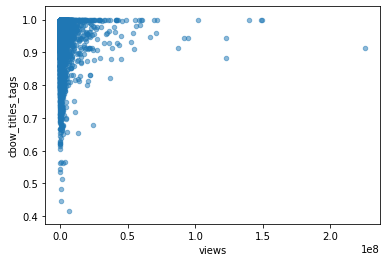

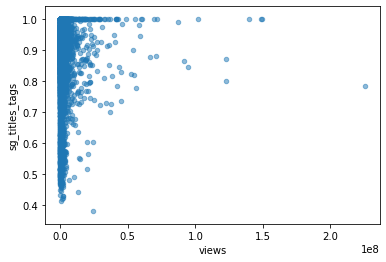

In [35]:
videos.plot(kind="scatter", x="views", y="cbow_titles_tags", alpha=0.5)
# use colors to show clusters of views 100k - 200k ...
# does it cluser well with title, description, tags..
videos.plot(kind="scatter", x="views", y="sg_titles_tags", alpha=0.5)

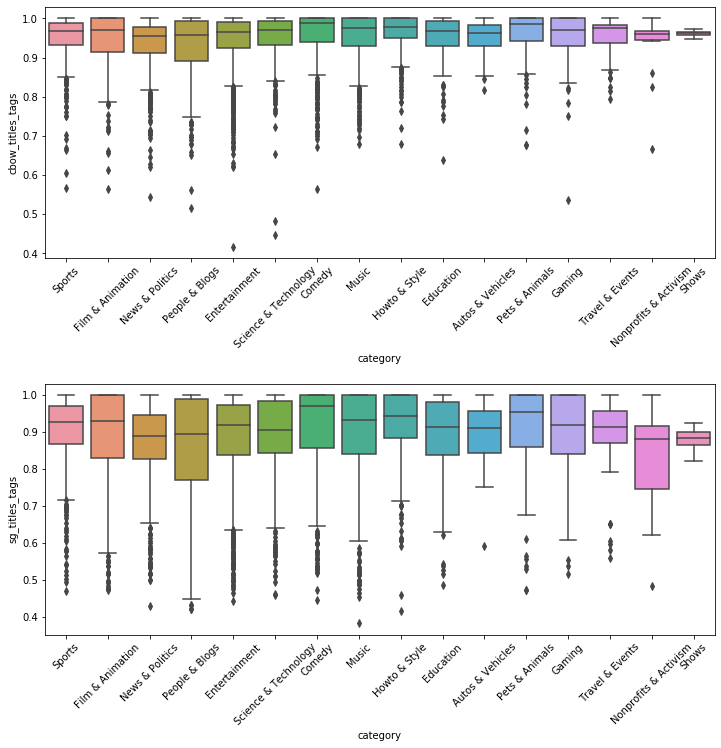

In [36]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_tags',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_tags',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

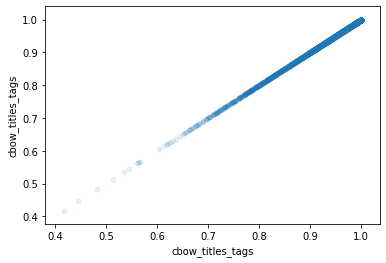

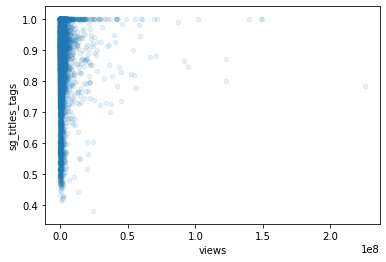

In [39]:
videos.plot(kind="scatter", x="cbow_titles_tags", y="cbow_titles_tags", alpha=0.1)
# use colors to show clusters of views 100k - 200k ...
# does it cluser well with title, description, tags..
videos.plot(kind="scatter", x="views", y="sg_titles_tags", alpha=0.1)

In [0]:
from sklearn.neighbors import NearestNeighbors

def create_coordinates(videos):
  coordinate_list = []
  index =0
  for score in videos['cbow_titles_tags']:
    coordinate_list.append([score, index])
    index +=1
  return coordinate_list

coordinates = create_coordinates(videos)
model = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(coordinates)
distances, indices = model.kneighbors(coordinates)

print(distances)
print(len(videos['cbow_titles_tags']))

print(indices)

plt.scatter(distances, videos['cbow_titles_tags'].tolist,  c='k')
plt.axis('tight')
plt.tight_layout()
plt.show()
# print(np.array(videos['cbow_titles_tags'].apply(lambda x: [x,videos['cbow_titles_tags']])))

# model.kneighbors_graph(coordinates).toarray()

In [0]:
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(videos['cbow_titles_tags'], videos['cbow_titles_tags']).predict(videos)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(T, y_, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.tight_layout()
plt.show()

In [0]:
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets


h = .02
# Calculate min, max and limits
x_min, x_max = -50, 100
y_min, y_max = -50, 100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Put the result into a color plot
plt.figure()
plt.scatter(indices, videos['cbow_titles_tags'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Data points")
plt.show()

# Compare titles and descriptions

**Using Word2Vec neural networks, get the similarities of titles and descriptions**

In [0]:
cbow, sg = word2vecNLP(titles_list, descriptions_list)

In [0]:
# add lists to dataframe
videos["cbow_titles_descriptions"] = cbow
videos["sg_titles_descriptions"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_descriptions"] = videos["cbow_titles_descriptions"].replace(0, videos["cbow_titles_descriptions"].mean())
videos["sg_titles_descriptions"] = videos["sg_titles_descriptions"].replace(0, videos["sg_titles_descriptions"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between titles and descriptions - CBOW:     {0:.4f}".format(videos["cbow_titles_descriptions"].mean()))
print("Cosine similarity between titles and descriptions - SG:       {0:.4f}".format(videos["sg_titles_descriptions"].mean()))

**Visualization**

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_descriptions", alpha=0.5)
# transpose x=corr and clustering knn for unseen video, k videos that have largest cosine similarity, sets of keywords in clusters, 
videos.plot(kind="scatter", x="views", y="sg_titles_descriptions", alpha=0.5)

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_tags',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_tags',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Compare titles and channels

**Using Word2Vec neural networks, get the similarities of titles and channels**

In [0]:
cbow, sg = word2vecNLP(titles_list, channels_list)

In [0]:
# add lists to dataframe
videos["cbow_titles_channels"] = cbow
videos["sg_titles_channels"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_channels"] = videos["cbow_titles_channels"].replace(0, videos["cbow_titles_channels"].mean())
videos["sg_titles_channels"] = videos["sg_titles_channels"].replace(0, videos["sg_titles_channels"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between titles and channels - CBOW:     {0:.4f}".format(videos["cbow_titles_channels"].mean()))
print("Cosine similarity between titles and channels - SG:       {0:.4f}".format(videos["sg_titles_channels"].mean()))

**Visualization**

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_channels", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_titles_channels", alpha=0.5)

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_channels',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_channels',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Compares titles and categories

**Using Word2Vec neural networks, get the similarities of titles and categories**

In [0]:
cbow, sg = word2vecNLP(titles_list, categories_list)

In [0]:
# add lists to dataframe
videos["cbow_titles_categories"] = cbow
videos["sg_titles_categories"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_titles_categories"] = videos["cbow_titles_categories"].replace(0, videos["cbow_titles_categories"].mean())
videos["sg_titles_categories"] = videos["sg_titles_categories"].replace(0, videos["sg_titles_categories"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between titles and categories - CBOW:     {0:.4f}".format(videos["cbow_titles_categories"].mean()))
print("Cosine similarity between titles and categories - SG:       {0:.4f}".format(videos["sg_titles_categories"].mean()))

**Visualization**

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_titles_categories", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_titles_categories", alpha=0.5)

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_titles_categories',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_titles_categories',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Compare tags and categories

**Using Word2Vec neural networks, get the similarities of tags and categories**

In [0]:
cbow, sg = word2vecNLP(tags_list, categories_list)

In [0]:
# add lists to dataframe
videos["cbow_tags_categories"] = cbow
videos["sg_tags_categories"] = sg

In [0]:
# replace 0 values with mean
videos["cbow_tags_categories"] = videos["cbow_tags_categories"].replace(0, videos["cbow_tags_categories"].mean())
videos["sg_tags_categories"] = videos["sg_tags_categories"].replace(0, videos["sg_tags_categories"].mean())

**Average Similarities**

In [0]:
print("Cosine similarity between tags and categories - CBOW:     {0:.4f}".format(videos["cbow_tags_categories"].mean()))
print("Cosine similarity between tags and categories - SG:       {0:.4f}".format(videos["sg_tags_categories"].mean()))

**Visualization**

In [0]:
videos.plot(kind="scatter", x="views", y="cbow_tags_categories", alpha=0.5)
videos.plot(kind="scatter", x="views", y="sg_tags_categories", alpha=0.5)

In [0]:
# source https://www.kaggle.com/kabure/extensive-usa-youtube-eda

plt.figure(figsize = (12,18))

plt.subplot(311)
cat_graph_1 = sns.boxplot(x='category',y='cbow_tags_categories',  data=videos)
cat_graph_1.set_xticklabels(cat_graph_1.get_xticklabels(),rotation=45)

plt.subplot(312)
cat_graph_2 = sns.boxplot(x='category',y='sg_tags_categories',  data=videos)
cat_graph_2.set_xticklabels(cat_graph_2.get_xticklabels(),rotation=45)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.9)

plt.show()

# Classification

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from inspect import signature
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neural_network import MLPClassifier
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
UNITED_STATES_VID = "/content/drive/My Drive/cs6140 project/data/USvideos.csv"
videos = pd.read_csv(UNITED_STATES_VID)

UNITED_STATES_CAT = "/content/drive/My Drive/cs6140 project/data/US_category_id.json"
videos_categories = pd.read_json(UNITED_STATES_CAT)

In [0]:
# source: https://www.kaggle.com/skalskip/youtube-data-exploration-and-plotly-visualization

categories = {category['id']: category['snippet']['title'] for category in videos_categories['items']}
videos.insert(4, 'category', videos['category_id'].astype(str).map(categories))

# Classify `category` using NLP

In [29]:
videos.head()

,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,Entertainment,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [0]:
train_dataset = videos.sample(frac=0.8,random_state=12345)
test_dataset = videos.drop(train_dataset.index)

train_dataset['title'] = train_dataset['title'].apply(str)
test_dataset['title'] = test_dataset['title'].apply(str)

train_dataset.drop_duplicates(subset="title", keep="last", inplace=True)
test_dataset.drop_duplicates(subset="title", keep="last", inplace=True)

train_dataset = train_dataset.dropna()
test_dataset = test_dataset.dropna()

# get labels
train_labels = train_dataset.pop('category')
test_labels = test_dataset.pop('category')

# min_max_scaler = preprocessing.MinMaxScaler()

# # normalize train
# x = train_dataset.values
# normed_train = min_max_scaler.fit_transform(x)
# train_dataset = pd.DataFrame(normed_train)

# # normalize test
# x = test_dataset.values
# normed_test = min_max_scaler.fit_transform(x)
# test_dataset = pd.DataFrame(normed_test)

In [31]:
train_dataset.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
17198,ETabBP9tUD4,18.10.02,Catchphrase with Andrew Garfield and Rachel Br...,The Tonight Show Starring Jimmy Fallon,23,2018-02-09T12:00:01.000Z,"The Tonight Show|""Jimmy Fallon""|""Catchphrase""|...",114967,2783,54,201,https://i.ytimg.com/vi/ETabBP9tUD4/default.jpg,False,False,False,Jimmy teams up with Rachel Brosnahan against A...
6001,pA5NbgdpRpk,17.14.12,"Lavar Ball & Sons On Family Business, Discipli...",Breakfast Club Power 105.1 FM,24,2017-12-13T12:59:47.000Z,"the breakfast club|""power1051""|""celebrity news...",764775,20132,1600,7991,https://i.ytimg.com/vi/pA5NbgdpRpk/default.jpg,False,False,False,► Listen LIVE: http://power1051fm.com/\n► Face...
4958,Yxv5EY-JwmU,17.08.12,At Home with Amy Sedaris - Astronaut Relations...,truTV,24,2017-12-04T19:22:14.000Z,"truTV|""tru""|""funny because its tru""|""truTV tru...",4232,49,4,4,https://i.ytimg.com/vi/Yxv5EY-JwmU/default.jpg,False,False,False,Why did the astronaut leave his wife? One sexu...
14148,trW9rxpSBxA,18.25.01,Worlds Record Basketball Shot 200m (660 feet) ...,How Ridiculous,17,2018-01-19T22:00:05.000Z,"how ridiculous|""world record""|""guinness world ...",359057,7478,103,732,https://i.ytimg.com/vi/trW9rxpSBxA/default.jpg,False,False,False,World Record Highest Basketball Shot (201.422m...
5540,tvs3yvEcARA,17.11.12,3D Printed Monster Spitfire | FLITE TEST,FliteTest,24,2017-12-06T20:30:00.000Z,"Flite Test|""remote controlled""|""unmanned""|""dro...",90458,3135,27,379,https://i.ytimg.com/vi/tvs3yvEcARA/default.jpg,False,False,False,MORE INFO: https://www.flitetest.com/articles/...


**Testing and Metrics Function**

In [0]:
"""
function: test_model
params: clf, a function
returns: nothing
does: prints out confusion matrix, precision, recall, f-score, and ROC AUC
"""
def test_model(clf): # add in y_pred, y_labels
  y_pred = clf.predict(test_dataset['title'])
  metrics = precision_recall_fscore_support(y_true=test_labels, y_pred=y_pred, average='weighted')
  accuracy = accuracy_score(test_labels, y_pred, normalize=True)
  print('Test Precision: %.5f' %metrics[0])
  print('Test Recall: %.5f' %metrics[1])
  print('Test F-Score: : %.5f' %metrics[2])
  print('Test Accuracy: : %.5f' %accuracy)

  # auc = roc_auc_score(test_labels, clf.predict_proba(test_dataset['title'])[:,1])
  # print('Test ROC AUC: %.5f' %auc)

**Model Creation and Testing**

`FeatureUnion` combines two `TfidfVectorizers` to clean text for our model

In [0]:
vectorizerW = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=None, ngram_range = (1,1), max_df=1.0, min_df=1, max_features=None, norm = 'l2')
vectorizerC = TfidfVectorizer(lowercase=True, analyzer='char', stop_words=None, ngram_range = (1,1), max_df=1.0, min_df=1, max_features=None, norm = 'l2')
combined_features = FeatureUnion([('word', vectorizerW), ('char', vectorizerC)])

Next, we test a model. We chose `LogisticRegressionCV` as an initial model

In [45]:
clf = Pipeline([
    ('features', combined_features),
    ('clf', LogisticRegressionCV(cv=3, solver='newton-cg', n_jobs=-1, multi_class='multinomial')),
])

clf = clf.fit(train_dataset['title'], train_labels)
test_model(clf)

Test Precision: 0.98388
Test Recall: 0.98385
Test F-Score: : 0.98383
Test Accuracy: : 0.98385


It generated a pretty good score, so there isn't much improvement to make